<a href="https://colab.research.google.com/github/derzhavin3016/CompMath/blob/master/Lab4/Lab4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Домашняя лабораторная работа №4 по вычислительной математике

Державин Андрей, Б01-909 группа


## Задача __VI.9.32__

### Метод Ньютона

In [1]:
import numpy as np
import pandas as pd

In [2]:
pUSA = {
    1910: 92_228_496,
    1920: 106_021_537,
    1930: 123_202_624,
    1940: 132_164_569,
    1950: 151_325_798,
    1960: 179_323_175,
    1970: 203_211_926,
    1980: 226_545_805,
    1990: 248_709_873,
    2000: 281_421_906
}

years = list(pUSA.keys())
pop = list(pUSA.values())

pop2010 = 308_745_538

In [3]:
def fillB(x, f):
  assert len(x) == len(f), 'x and f are not equal!!'
  b = [[0] * (len(f) - i) for i in range(len(f))]

  for i, _ in enumerate(f):
    if i == 0:
      for j in range(len(f)):
        b[0][j] = f[j]
    else:
      for j in range(len(b[i])):
        bi1 = b[i - 1]
        b[i][j] = (bi1[j + 1] - bi1[j]) / (x[j + i] - x[j])
  return b

b = fillB(years, pop)

df = pd.DataFrame(data=b, index=[f'b{i}' for i in range(len(b))])
df = df.transpose()
df['x'] = years
cols = list(df.columns)
cols = cols[10:] + cols[:10]
df = df.reindex(columns=cols)
df

,x,b0,b1,b2,b3,b4,b5,b6,b7,b8,b9
0,1910,92228496.0,1379304.1,16940.230,-1934.531333,125.106725,-4.150598,0.080565,-0.000756,-0.000008,5.099328e-07
1,1920,106021537.0,1718108.7,-41095.710,3069.737667,-82.423175,0.683327,0.027611,-0.001362,0.000038,NaN
2,1930,123202624.0,896194.5,50996.420,-227.189333,-48.256825,2.340014,-0.067705,0.001705,NaN,NaN
3,1940,132164569.0,1916122.9,44180.740,-2157.462333,68.743867,-1.722268,0.051623,NaN,NaN,NaN
4,1950,151325798.0,2799737.7,-20543.130,592.292333,-17.369554,1.375117,NaN,NaN,NaN,NaN
5,1960,179323175.0,2388875.1,-2774.360,-102.489833,51.386312,NaN,NaN,NaN,NaN,NaN
6,1970,203211926.0,2333387.9,-5849.055,1952.962667,NaN,NaN,NaN,NaN,NaN,NaN
7,1980,226545805.0,2216406.8,52739.825,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,1990,248709873.0,3271203.3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,2000,281421906.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Так как 2010 ближе к нижнему концу таблицы, возьмем нижние числа (нижняя диагональ)

In [10]:
n_coeffs = [bi[-1] for bi in b]
n_coeffs

def Newt(x, data_x, cfs):
  res = 0
  for i, bi in enumerate(cfs):
    mul = bi
    for j in range(i):
      mul *= x - data_x[len(data_x) - j - 1]
    res += mul
  return res

prog = int(Newt(2010, years, n_coeffs))
print(f'Прогноз = {prog}')
print(f'Delta = {prog - pop2010}')

Прогноз = 827906509
Delta = 519160971


### Метод сплайнов


Используем кубический сплайн вида 
$$S(x) = a_i + b_i (x- x_i) + \frac{c_i}{2} (x-x_i)^2 +  \frac{d_i}{6} (x-x_i)^3$$ Зададим граничные условия как 
$$
f''(1910) = f''(2000) = 0
$$

In [8]:
from numpy.polynomial.polynomial import Polynomial as Poly
from matplotlib import pyplot as plt

Нахождение коэффициентов сплайна осуществляется через коэффициенты $c_i$, являющимися решениями уравнения $Mx = f$, где
$$
M = 
\left(
\begin{matrix}
C_1 & B_1 & 0 & 0 & \dots & 0 & 0\\
A_2 & C_2 & B_2 & 0 & \dots & 0 & 0\\
0 & A_3 & C_3 & B_3 & \dots & 0 & 0\\
\dots & \dots & \dots & \dots & \dots & \dots & \dots\\
\dots & \dots & \dots & \dots & \dots & \dots & B_{n-1}\\
C_1 & B_1 & 0 & 0 & \dots & A_n & C_n\\
\end{matrix}
\right), где \: n=8
$$
Граничные условия выражаются как $$c_0 = c_{10} = 0$$
$$
A_i = x_i - x_{i-1}, i = \overline{2\dots n}, \: \:
B_i = x_{i+1} - x_{i}, i = \overline{1\dots n-1}, \:\:
C_i = 2\cdot\left(x_{i+1} - x_{i-1}\right), i = \overline{1\dots n}
$$
$$
F_i = 6 \cdot \left(
\frac{y_{i+1} - y_i}{x_{i+1} - x_i} - 
\frac{y_{i} - y_{i-1}}{x_{i} - x_{i-1}}
\right)
$$

In [5]:
N = len(years) - 2
M = np.zeros(shape=(N, N))
for i in range(N):
  if i != N - 1:
    M[i][i + 1] = years[i + 2] - years[i + 1]
  M[i][i] = 2 * (years[i + 2] - years[i])
  if i != 0:
    M[i][i - 1] = years[i + 1] - years[i]

b_col = np.zeros(shape=(N, 1))
for i, elem in enumerate(b_col):
  h_i = years[i + 1] - years[i]
  h_i1 = years[i + 2] - years[i + 1]
  b_col[i] = 6 * ((pop[i + 2] - pop[i + 1]) / h_i1 - (pop[i + 1] - pop[i]) / h_i) 

In [6]:
def run_through(matr, b):
  # tun though coeffs
  assert b.shape[0] == matr.shape[1], "Ivalid sizes"

  sz = b.shape[0]
  x = np.zeros(sz)
  alpha = np.zeros(sz)
  beta = np.zeros(sz)

  c = matr[0][0]
  alpha[0] = - matr[0][1] / c
  beta[0] = b[0] / c

  # direct  run through
  for k in range(1, sz):
    c = matr[k][k] + matr[k][k - 1] * alpha[k - 1]
    if k != sz - 1: 
      alpha[k] = - matr[k][k + 1] / c
    beta[k] = (b[k] - matr[k][k - 1] * beta[k - 1]) / c

  x[-1] = beta[-1]

  for k in range(sz - 2, -1, -1):
    x[k] = alpha[k] * x[k + 1] + beta[k]
  
  return x

coeffs = np.zeros(shape=(N + 1, 4))
sol = run_through(M, b_col)

for k, coef in enumerate(coeffs):
  hk = years[k + 1] - years[k]
  coef[0] = pop[k + 1]
  ck = coef[2] = sol[k] / 2 if k < len(sol) else 0
  ck_prev = coeffs[k - 1][2] if k != 0 else 0

  coeffs[k][3] = (ck - ck_prev) / (3 * hk)
  coeffs[k][1] = (pop[k + 1] - pop[k]) / hk + (2 * ck + ck_prev) * hk / 3

polys = [Poly(cfs) for cfs in coeffs]

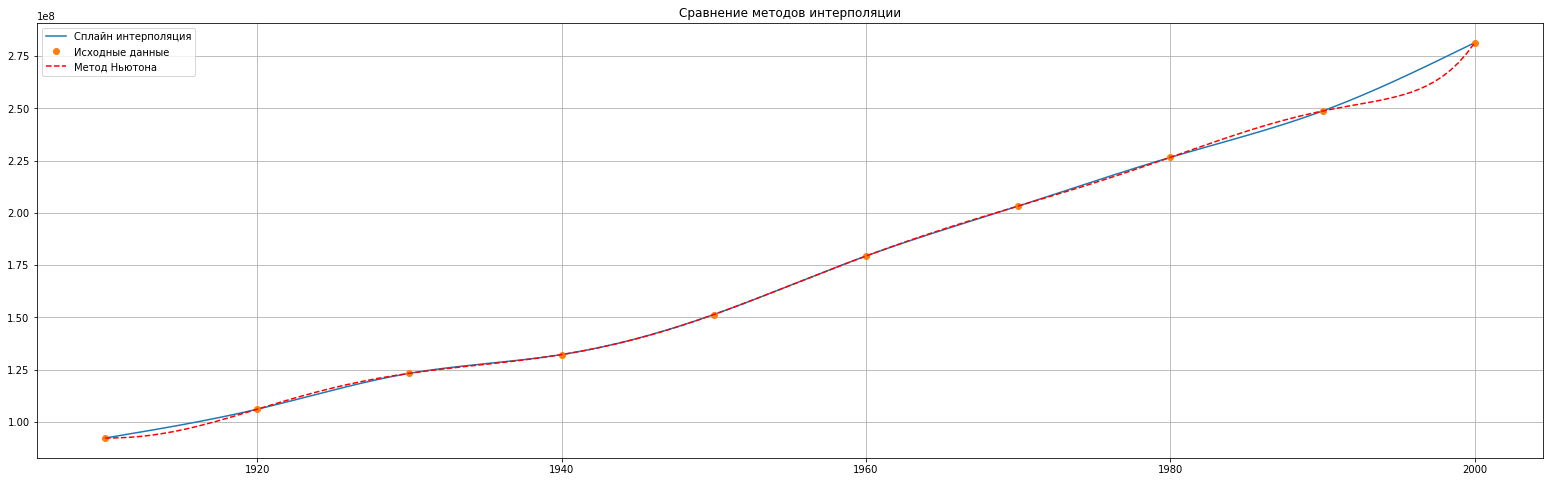

In [11]:
plt.figure(figsize=[27, 8])
Y = []
X = []
for i, pol in enumerate(polys):
  z = np.linspace(-years[i + 1] + years[i], 0, num=20)
  Y += list(pol(z))
  X += list(np.linspace(years[i], years[i + 1], num=20))

plt.title('Сравнение методов интерполяции')
plt.plot(X, Y, label='Сплайн интерполяция')
plt.plot(years, pop, 'o', label='Исходные данные')
newton_y = [Newt(x, years, n_coeffs) for x in X]
plt.plot(X, newton_y, '--r', label='Метод Ньютона')
plt.legend()
plt.grid()

In [12]:
calc2010 = polys[-1](2010 - 2000)
print(f'Исходное значение за 2010: {pop2010}')
print(f'Посчитанное методом сплайн за 2010: {calc2010}')
print(f'Посчитанное методом Ньютона за 2010: {prog}')

Исходное значение за 2010: 308745538
Посчитанное методом сплайн за 2010: 314133939.0
Посчитанное методом Ньютона за 2010: 827906509


Как мы видим, при сплайн-интерполяции получено более точное приближение, чем при методе Ньютона